<a href="https://colab.research.google.com/github/ambideXtrous9/Brand-Logo-Classification-using-TransferLearning-Flickr27/blob/main/Flickr27_Xception_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet imutils
!pip install --quiet wget
!pip install --quiet split-folders
!pip install --quiet timm

In [2]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import timm
import numpy as np
import os
import wget
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## Downloading Dataset

In [3]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar (1).gz'

In [4]:
!ls

 data				 'flickr_logos_27_dataset.tar (1).gz'   sample_data
 flickr_logos_27_dataset	  flickr_logos_27_dataset.tar.gz
 flickr_logos_27_dataset_images   LOGOS


In [5]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

In [6]:
import tarfile

fname = 'flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
fname = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [8]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [11]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [12]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [13]:
dtdir = './flickr_logos_27_dataset_images/'

In [14]:
im = df[0][0]

In [15]:
size = df.iloc[:,3:]

In [16]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [17]:
img = os.path.join(dtdir,im)

In [18]:
size = size.values.tolist()

In [19]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

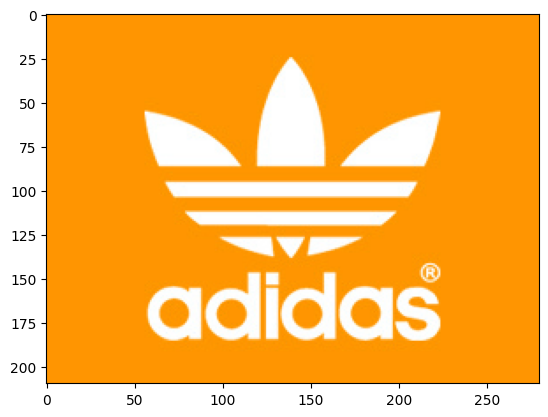

In [20]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

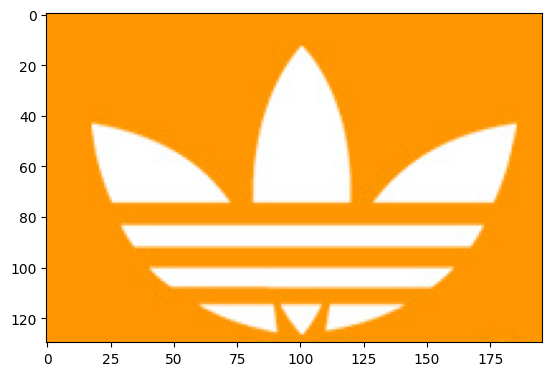

In [21]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [22]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [23]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

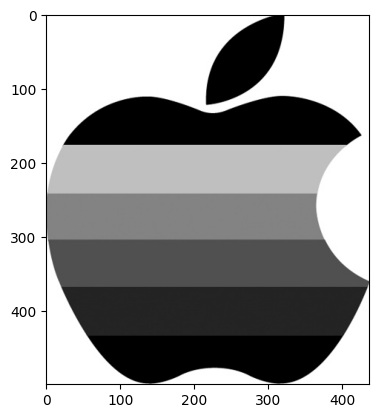

In [24]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [25]:
y = list(set(list(Y)))
y.sort()

In [26]:
for i in y:
    os.makedirs(os.path.join(dest,i))

FileExistsError: [Errno 17] File exists: 'LOGOS/Adidas'

In [ ]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [ ]:
distractor

In [ ]:
HEIGHT = 224
WIDTH =  224
BS = 256

## Removing Corrupt Images

In [ ]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

In [ ]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [ ]:
A

In [ ]:

for i in range(len(A)):
    try:
        destrain = os.path.join(dest,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [ ]:
imagePaths = list(paths.list_images(dest))

In [ ]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Train Val Split

In [ ]:
path = 'LOGOS'

In [ ]:
splitfolders.ratio(path, output="data", seed=42, ratio=(0.8,0.2))

In [ ]:
import random
def set_seed(seed):
    # Set seed for Python's random module
    random.seed(seed)

    # Set seed for NumPy
    np.random.seed(seed)

    # Set seed for PyTorch
    torch.manual_seed(seed)

    # If you are using GPUs
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If you are using multi-GPU

    # Ensure reproducibility for convolutional operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
set_seed(42)

## Image Augmentation

In [ ]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(WIDTH,HEIGHT))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
coljtr = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
raf = transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15)
rrsc = transforms.RandomResizedCrop(size=WIDTH, scale=(0.8, 1.0))
ccp  = transforms.CenterCrop(size=WIDTH)  # Image net standards
nrml = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards

In [ ]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])
valTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])

In [ ]:
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root='./data/train',transform=trainTransforms)
valDataset = ImageFolder(root='./data/val', transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

In [ ]:
# create training and validation set dataloaders
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset, batch_size=BS, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BS,shuffle=True)

In [ ]:
examples = iter(valDataLoader)
example_data, example_targets = next(examples)
for i in range(9):
    plt.subplot(3,3,i+1)
    img =example_data[i].cpu().numpy().T
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [ ]:
import torchvision.models as models

In [ ]:
print(trainDataset.class_to_idx)

## Model Architecture - Xception!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## **Xception**

In [ ]:
def Xception(requires_grad=True,hidden_dim = 256):
    model = timm.create_model('xception', pretrained=True)
    model.aux_logits=False

    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = requires_grad

    model.fc = nn.Sequential(
                          nn.BatchNorm1d(model.fc.in_features),
                          nn.Linear(model.fc.in_features, hidden_dim),
                          nn.Dropout(0.5),
                          nn.ReLU(inplace=True),
                          nn.BatchNorm1d(hidden_dim),
                          nn.Linear(hidden_dim, len(trainDataset.classes)),
                          nn.Softmax(dim=1))
    return model.to(device)


## **EfficientNetB0**

In [ ]:
def EfficientNet(requires_grad=True,hidden_dim = 256):
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model.aux_logits=False

    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = requires_grad

    model.classifier = nn.Sequential(
                    nn.BatchNorm1d(model.classifier.in_features),
                    nn.Dropout(0.4),
                    nn.ReLU(inplace=True),
                    nn.Linear(model.classifier.in_features, hidden_dim),
                    nn.Dropout(0.4),
                    nn.ReLU(inplace=True),
                    nn.BatchNorm1d(hidden_dim),
                    nn.Linear(hidden_dim, len(trainDataset.classes)),
                    nn.Softmax(dim=1))

    return model.to(device)


## Train Function

In [ ]:
def train(epoch,model,loss_func,optimizer):
  model.train()
  net_loss = 0
  correct = 0
  for batch_idx, (data, target) in enumerate(trainDataLoader):
    (data, target) = (data.to(device), target.to(device))
    optimizer.zero_grad()
    output = model(data)
    loss = loss_func(output, target)
    output = torch.exp(output)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    loss.backward()
    optimizer.step()

    net_loss += loss.item()
  acc = correct / len(trainDataLoader.dataset)
  return net_loss,acc

## Test Function

In [ ]:
def test(model,loss_func):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in valDataLoader:
      (data, target) = (data.to(device), target.to(device))
      output = model(data)
      test_loss += loss_func(output, target).item()
      output = torch.exp(output)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  # test_loss /= len(valDataLoader.dataset)
  acc = correct / len(valDataLoader.dataset)
  return test_loss,acc

## **Driver Code**

In [ ]:
import time

def Trainer(model,loss_func,optimizer,n_epochs):
    LOSSTR = []
    ACCTE = []
    LOSSTE = []
    ACCTR = []
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        print("--- Epoch {} ---".format(epoch))
        epoch_loss,tracc = train(epoch=epoch,model=model,loss_func=loss_func,optimizer=optimizer)
        LOSSTR.append(epoch_loss)
        ACCTR.append(tracc)
        print("\tTrain Accuracy = {} || Train Loss  = {} ".format(tracc,epoch_loss))
        tloss,tacc =  test(model=model,loss_func=loss_func)
        print("\tTest Accuracy =  {} || Test Loss = {} ".format(tacc,tloss))
        ACCTE.append(tacc)
        LOSSTE.append(tloss)
        stop = time.time()
        print("\tTraining time = ", (stop - start))
    return LOSSTR,ACCTE,LOSSTE,ACCTR

## **Accuracy - Loss Plot**

In [ ]:
def plot(LOSSTR,ACCTE,LOSSTE,ACCTR,n_epochs):
    xx = np.arange(n_epochs)
    plt.style.use("fivethirtyeight")

    acctr = torch.Tensor(ACCTR).detach().cpu().numpy()
    lsstr = torch.Tensor(LOSSTR).detach().cpu().numpy()
    accte = torch.Tensor(ACCTE).detach().cpu().numpy()
    lsste = torch.Tensor(LOSSTE).detach().cpu().numpy()

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
    fig.suptitle('ACC vs LOSS')
    ax1.plot(xx, acctr,label='Train')
    ax1.plot(xx,accte,label='Val')
    ax1.legend(loc="best")
    ax2.plot(xx, lsstr,label='Train')
    ax2.plot(xx, lsste,label='Val')
    ax2.legend(loc="best")
    plt.show()

## **Prediction On Test Images**

In [ ]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

In [ ]:
transform_norm = transforms.Compose([
            transforms.ToTensor(),
            resize,
            nrml])

In [ ]:
from PIL import Image


In [ ]:
def predimg(path,model):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    model.eval()
    input_tensor = transform_norm(image).unsqueeze(0).to(device)  # Add batch dimension

    # Measure inference time
    start_time = time.time()

    with torch.no_grad():
        output = model(input_tensor)
        # Get the predicted class index
        index = torch.argmax(output).item()

    end_time = time.time()
    inference_time = end_time - start_time

    predicted_class = trainDataset.classes[index]
    predprob = round(output[0][index].item(),2)
    if(predprob < 0.80) : predicted_class = 'None'
    print("Accuracy = ",predprob)
    print("PREDICTED CLASS = ",predicted_class)

## **Model Init, Loss Function and Optimizer**

In [205]:
n_epochs = 20
model = EfficientNet(requires_grad=False)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
LOSSTR,ACCTE,LOSSTE,ACCTR = Trainer(model,loss_func,optimizer,n_epochs)

--- Epoch 1 ---
	Train Accuracy = 0.046357616782188416 || Train Loss  = 9.874888181686401 
	Test Accuracy =  0.15343914926052094 || Test Loss = 3.2917962074279785 
	Training time =  10.498067378997803
--- Epoch 2 ---
	Train Accuracy = 0.1748344451189041 || Train Loss  = 9.813775777816772 
	Test Accuracy =  0.3809523582458496 || Test Loss = 3.2829837799072266 
	Training time =  10.898967027664185
--- Epoch 3 ---
	Train Accuracy = 0.27417218685150146 || Train Loss  = 9.72000765800476 
	Test Accuracy =  0.4656084477901459 || Test Loss = 3.2663772106170654 
	Training time =  11.24556303024292
--- Epoch 4 ---
	Train Accuracy = 0.3615894019603729 || Train Loss  = 9.558144807815552 
	Test Accuracy =  0.4285714030265808 || Test Loss = 3.2304110527038574 
	Training time =  11.187589883804321
--- Epoch 5 ---
	Train Accuracy = 0.41192054748535156 || Train Loss  = 9.443149089813232 
	Test Accuracy =  0.4497354328632355 || Test Loss = 3.1777687072753906 
	Training time =  11.47052550315857
--- Epoc

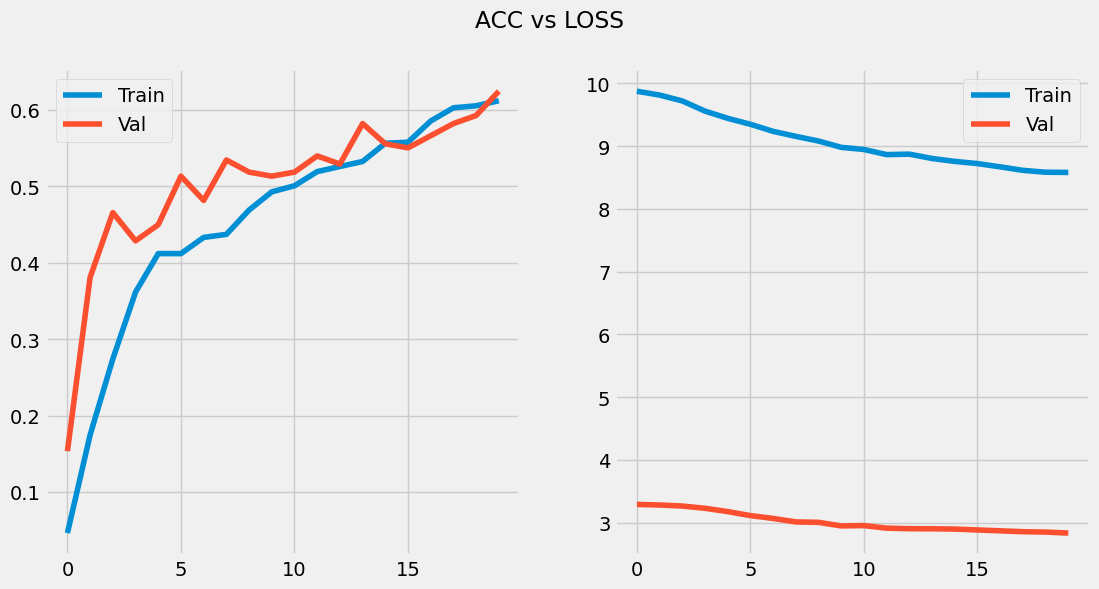

In [206]:
plot(LOSSTR,ACCTE,LOSSTE,ACCTR,n_epochs)

## **Predictions**

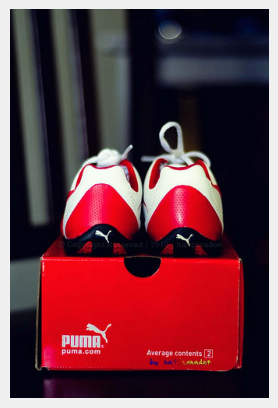

Accuracy =  0.14
PREDICTED CLASS =  None


In [207]:
predimg(testimage[8],model)

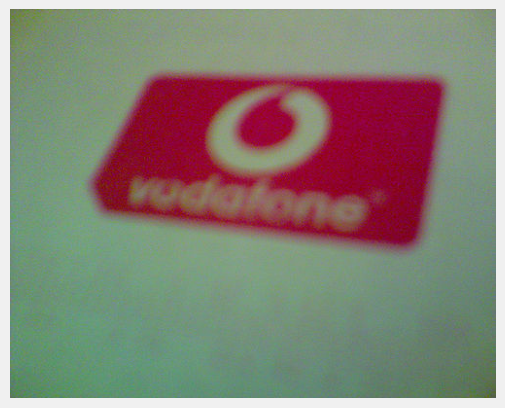

Accuracy =  0.35
PREDICTED CLASS =  None


In [208]:
predimg(testimage[5],model)

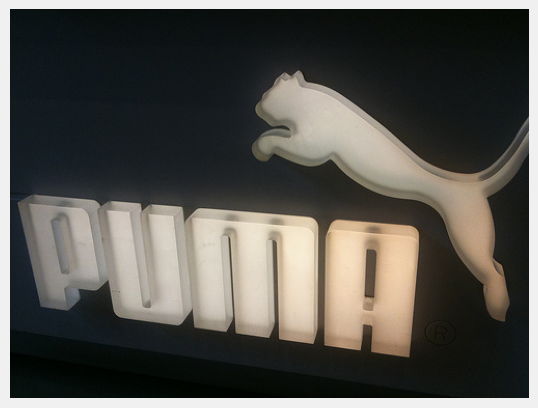

Accuracy =  0.62
PREDICTED CLASS =  None


In [209]:
predimg(testimage[31],model)

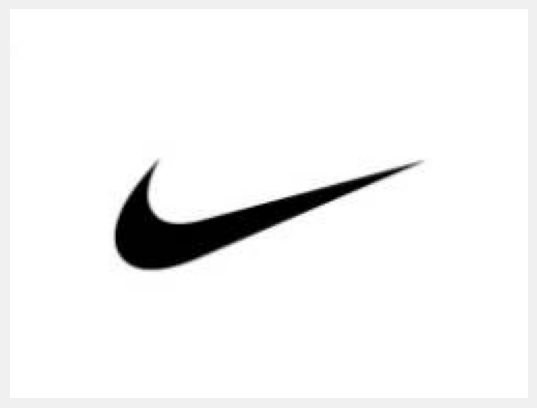

Accuracy =  0.15
PREDICTED CLASS =  None


In [211]:
predimg(testimage[63],model)

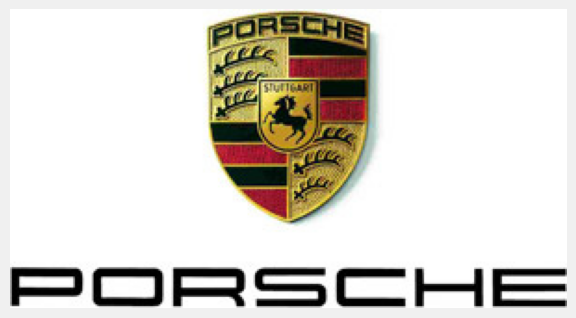

Accuracy =  0.95
PREDICTED CLASS =  Porsche


In [212]:
predimg(testimage[85],model)

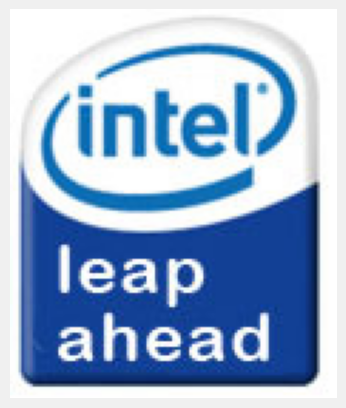

Accuracy =  0.35
PREDICTED CLASS =  None


In [213]:
predimg(testimage[80],model)

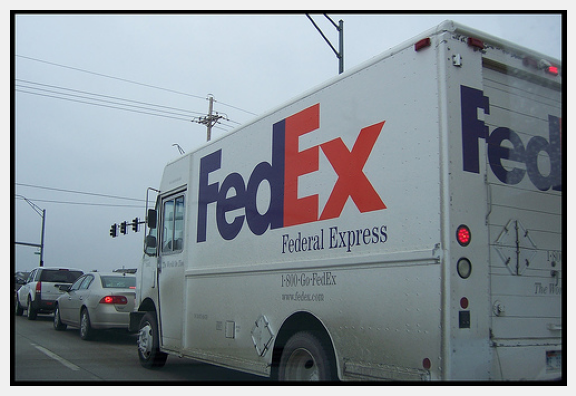

Accuracy =  0.24
PREDICTED CLASS =  None


In [214]:
predimg(testimage[4],model)

## **Model Init, Loss Function and Optimizer**

In [216]:
n_epochs = 20
ftmodel = EfficientNet(requires_grad=True)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ftmodel.parameters())
LOSSTR,ACCTE,LOSSTE,ACCTR = Trainer(ftmodel,loss_func,optimizer,n_epochs)

--- Epoch 1 ---


OutOfMemoryError: CUDA out of memory. Tried to allocate 184.00 MiB. GPU 

In [ ]:
plot(LOSSTR,ACCTE,LOSSTE,ACCTR,n_epochs)

# **FineTune**

In [121]:
n_epochs = 20
LOSSTR,ACCTE,LOSSTE,ACCTR = Trainer(ftmodel,n_epochs)

--- Epoch 1 ---
	Train Accuracy = 0.8913907408714294 || Train Loss  = 1.855646789073944 
	Test Accuracy =  0.7513227462768555 || Test Loss = 0.005453895008753216 
	Training time =  14.889823913574219
--- Epoch 2 ---
	Train Accuracy = 0.8913907408714294 || Train Loss  = 1.7986794114112854 
	Test Accuracy =  0.7883597612380981 || Test Loss = 0.004903663403142697 
	Training time =  14.289947748184204
--- Epoch 3 ---
	Train Accuracy = 0.8635761737823486 || Train Loss  = 1.8537148833274841 
	Test Accuracy =  0.7830687761306763 || Test Loss = 0.0048750604271258 
	Training time =  14.313196897506714
--- Epoch 4 ---
	Train Accuracy = 0.8635761737823486 || Train Loss  = 1.8808029294013977 
	Test Accuracy =  0.7619047164916992 || Test Loss = 0.0052493611971537275 
	Training time =  14.54871916770935
--- Epoch 5 ---
	Train Accuracy = 0.8940397500991821 || Train Loss  = 1.7938328981399536 
	Test Accuracy =  0.7619047164916992 || Test Loss = 0.004915080688617847 
	Training time =  14.92952322959899

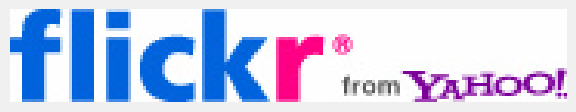

Accuracy =  0.05
PREDICTED CLASS =  None


In [124]:
predimg(testimage[10],model=ftmodel)